In [1]:
# imports
import torch
import torch.nn as nn  
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Marginal model
class MarginalModel(nn.Module):
    def __init__(self, num_layers=5, num_neurons=5, lr=0.01):
        super(MarginalModel, self).__init__()

        layers = [nn.Linear(1, num_neurons), nn.Tanh()]  # Input layer

        for _ in range(num_layers - 1):  # Hidden layers
            layers.append(nn.Linear(num_neurons, num_neurons))
            layers.append(nn.Tanh())

        layers.append(nn.Linear(num_neurons, 1))  # Output layer
        layers.append(nn.Sigmoid())

        self.fc = nn.Sequential(*layers)
        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        
        self.uniform_data = torch.tensor(np.linspace(0, 1, 10000), dtype=torch.float32).view(-1, 1)
        self.lower_bound = torch.tensor([[0.0]]) 
        self.upper_bound = torch.tensor([[1.0]])

    def forward(self, x):
        return self.fc(x)

    def loss_function(self, x):
        x.requires_grad = True
        self.uniform_data.requires_grad = True
        y_pred = self(x)
        y_pred_uniform = self(self.uniform_data)
        dydx = torch.autograd.grad(y_pred, x, torch.ones_like(y_pred), create_graph=True)[0]
        dydx_uniform = torch.autograd.grad(y_pred_uniform, self.uniform_data, torch.ones_like(y_pred_uniform), create_graph=True)[0]

        L1 = -torch.mean(torch.log(torch.relu(dydx) + 1e-8))
        L2 = torch.mean(torch.relu(-dydx_uniform))
        L3 = torch.abs(1 - torch.sum(dydx_uniform)/self.uniform_data.shape[0])
        L4 = self(self.lower_bound) + torch.abs(1 - self(self.upper_bound))
        Loss = L1*0.001 + L2 + L3 +  L4
        return Loss , L1, L2, L3, L4

    def train_model(self, X, epochs=5000, log_interval=500):
        for epoch in range(epochs):
            self.optimizer.zero_grad()
            loss, L1, L2, L3, L4 = self.loss_function(X)
            loss.backward()
            self.optimizer.step()

            if epoch % log_interval == 0:
                print(f'Epoch {epoch}, Loss: {loss.item()}, Constraint losses: L1: {L1.item()}, L2: {L2.item()}, L3: {L3.item()}, L4: {L4.item()}')

# Creating data
np.random.seed(0)
Z = np.random.standard_normal(10000)
scaling = 3.0
boundaryPoints = scaling * np.array([np.max(Z), np.min(Z)])

Z = np.concatenate((Z, boundaryPoints))
Z_squashed = (Z - np.min(Z)) / (np.max(Z) - np.min(Z))

X = torch.tensor(Z_squashed, dtype=torch.float32).view(-1, 1)

# Initialize and train the model with custom layers and neurons
model = MarginalModel(num_layers=6, num_neurons=10, lr=0.01)
model.train_model(X, epochs=5000, log_interval=500)




Epoch 0, Loss: 2.0219926834106445, Constraint losses: L1: 18.420686721801758, L2: 0.0011907066218554974, L3: 1.0011906623840332, L4: 1.0011906623840332
Epoch 500, Loss: -0.000600432395003736, Constraint losses: L1: -1.691911220550537, L2: 0.0, L3: 0.0005956888198852539, L4: 0.0004957900382578373
Epoch 1000, Loss: -0.0012733861804008484, Constraint losses: L1: -1.7007291316986084, L2: 0.0, L3: 0.0002636909484863281, L4: 0.00016365209012292325
Epoch 1500, Loss: -0.0014400981599465013, Constraint losses: L1: -1.703581690788269, L2: 0.0, L3: 0.00018173456192016602, L4: 8.174901449820027e-05
Epoch 2000, Loss: -0.0015092025278136134, Constraint losses: L1: -1.7059834003448486, L2: 0.0, L3: 0.00014841556549072266, L4: 4.836542211705819e-05
Epoch 2500, Loss: -0.0015454157255589962, Constraint losses: L1: -1.7080689668655396, L2: 0.0, L3: 0.00013136863708496094, L4: 3.1284624128602445e-05
Epoch 3000, Loss: -0.001566127990372479, Constraint losses: L1: -1.709088683128357, L2: 0.0, L3: 0.00012147

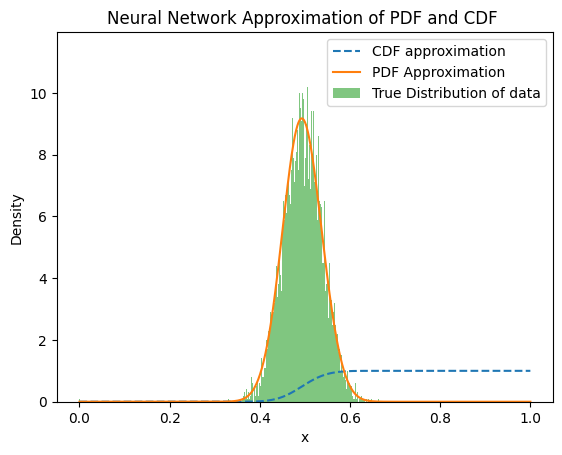

In [ ]:
# # Generate x values for plotting
x_points = np.linspace(0, 1, 100)
x_plot =torch.tensor(x_points, dtype=torch.float32).view(-1, 1)
x_plot.requires_grad = True  # Enable gradients for x_plot
y_pred = model(x_plot)  # Keep y_pred in computation graph
pdfPred = torch.autograd.grad(y_pred, x_plot, torch.ones_like(y_pred), create_graph=True)[0]

### Convert to numpy for plotting
#x_vals = x_plot.detach().numpy()
y_vals = y_pred.detach().numpy()
grad_vals = pdfPred.detach().numpy()

### Plot the neural network approximation
plt.plot(x_points, y_vals, label='CDF approximation', linestyle='dashed')
### Plot the derivative
plt.plot(x_points, grad_vals, label="PDF Approximation", linestyle='solid')
plt.hist(Z_squashed, bins=1000, density=True, alpha=0.6, label='True Distribution of data');
plt.legend()
plt.xlabel('x')
plt.ylabel('Density')
plt.title('Neural Network Approximation of PDF and CDF ')
plt.show()

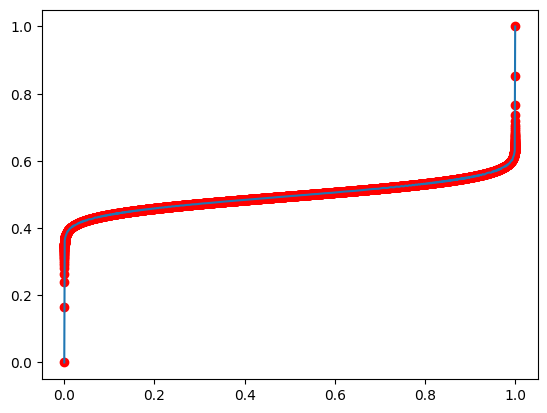

In [29]:
# Model created above
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.interpolate import BarycentricInterpolator
import scipy

def chebyshev_nodes(n, a, b):
    """Generate n Chebyshev nodes in the interval [a, b]."""
    return torch.tensor([0.5 * (a + b) + 0.5 * (b - a) * np.cos((2 * k + 1) * np.pi / (2 * n)) for k in range(n)], dtype=torch.float32)

def vectorized_bisection(f, y, tol=1e-6, max_iter=100):
    """
    Vectorized Bisection Method to find roots of a function f(y) in the interval [0,1] for multiple values of y simultaneously.
    
    Parameters:
    f : function
        The function whose roots are to be found.
    y : torch.Tensor
        Tensor of values for which roots are to be found.
    tol : float, optional
        The tolerance for stopping the iteration (default is 1e-6).
    max_iter : int, optional
        Maximum number of iterations (default is 100).
    
    Returns:
    torch.Tensor
        Tensor of estimated root values.
    """
    a, b = torch.zeros_like(y), torch.ones_like(y)
    fa, fb = f(a) , f(b) 
    fa, fb = fa - y, fb - y
    #assert torch.all(fa * fb < 0), "Function must have opposite signs at a and b for all intervals."
    # if not torch.all(fa * fb < 0):
    #     print("Warning: Some intervals do not contain a root. Adjusting bounds.")
    #     # Set problematic cases to the closest valid values
    #     a = torch.where(fa * fb >= 0, torch.zeros_like(y), a)
    #     b = torch.where(fa * fb >= 0, torch.ones_like(y), b)

    for _ in range(max_iter):
        c = (a + b) / 2  # Midpoint
        fc = f(c) - y
        
        left_mask = fc * fa < 0
        right_mask = fc * fb < 0
        
        a, b = torch.where(left_mask, a, c), torch.where(right_mask, b, c)
        
        if torch.all(torch.abs(b - a) < tol):
            break
    
    return (a + b) / 2

def tensor_interpolant(p_tensor, interpolant):
    """Interpolant function that takes PyTorch tensors as input."""
    p_numpy = p_tensor.detach().cpu().numpy()
    x_numpy = interpolant(p_numpy)
    return torch.tensor(x_numpy, dtype=torch.float32)

F = model

# Find range of marginal CDF
domainUpper = torch.tensor([[1.0]])
domainLower= torch.tensor([[0.0]])
rangeUpper = F(domainUpper)
rangeLower= F(domainLower)

# Generate Chebyshev nodes
n = 3000
rangePoints = chebyshev_nodes(n, rangeLower, rangeUpper).view(-1, 1)

# use nodes to find inverses
domainPoints = vectorized_bisection(F, rangePoints)

# Ensure rangePoints and domainPoints are 1D before interpolation
rangePoints = torch.cat((torch.tensor([0.0]), rangePoints.squeeze(), torch.tensor([1.0])))
domainPoints = torch.cat((torch.tensor([0.0]), domainPoints.squeeze(), torch.tensor([1.0])))

# Convert to NumPy arrays (1D)
rangePoints_np = rangePoints.numpy()
domainPoints_np = domainPoints.numpy()

# Create interpolator
interpolant = BarycentricInterpolator(rangePoints_np, domainPoints_np)

# Ensure vals is 1D before passing to interpolant
vals = np.linspace(0.0, 1.0, 1000)  # Already 1D, but let's be explicit
x = interpolant(vals)  # This should now work without shape issues

# Plot the inverse CDF approximation
# plt.plot(vals, x, label='Inverse CDF approximation')
# plt.scatter( rangePoints_np,domainPoints_np, color='red', label='Interpolation points')
# plt.title('Inverse CDF Approximation')
# plt.xlabel('Random number')
# plt.ylabel('Sampled value')
# plt.legend()
# plt.show()


# add boundary points (0 where 0 and 1 where 1)
# rangePoints = torch.cat((torch.tensor([[0.0]]), rangePoints, torch.tensor([[1.0]])))
# domainPoints = torch.cat((torch.tensor([[0.0]]), domainPoints, torch.tensor([[1.0]])))

#interpolant = BarycentricInterpolator(rangePoints.numpy(), domainPoints.numpy()) # interpolant using numpy arrays
interpolantTensor = lambda x: tensor_interpolant(x, interpolant) # interpolant using PyTorch tensors

# Plot the interpolant
vals = torch.tensor(np.linspace(0.0, 1.0, 1000)).view(-1, 1)
x = interpolantTensor(vals)
plt.plot(vals.numpy(), x.numpy(), label='Inverse CDF approximation')
plt.scatter(rangePoints_np, domainPoints_np, color='red', label='Interpolation points')


Text(0, 0.5, 'Sampled value')

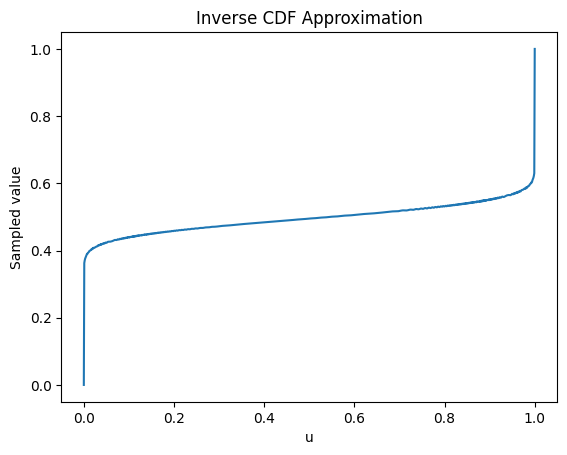

In [30]:
# Plot the interpolant
vals = np.linspace(0.0, 1.0, 1000)
x = interpolant(vals)
plt.plot(vals, x, label='Inverse CDF approximation')
plt.title('Inverse CDF Approximation')
plt.xlabel('u')
plt.ylabel('Sampled value')

# Solving for points for inverse CDF

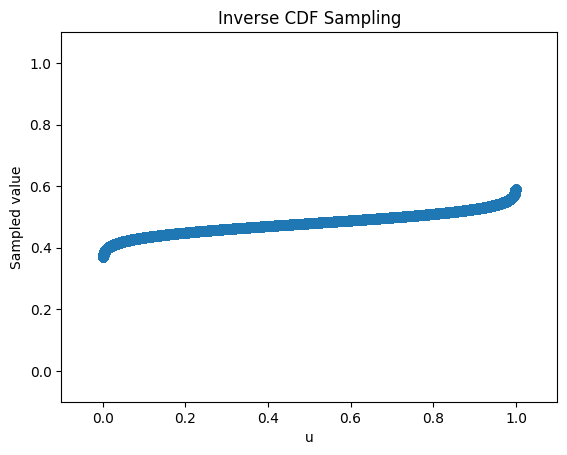

In [21]:
import torch

def vectorized_bisection(f, y, tol=1e-6, max_iter=100):
    """
    Vectorized Bisection Method to find roots of a function f(y) in the interval [0,1] for multiple values of y simultaneously.
    
    Parameters:
    f : function
        The function whose roots are to be found.
    y : torch.Tensor
        Tensor of values for which roots are to be found.
    tol : float, optional
        The tolerance for stopping the iteration (default is 1e-6).
    max_iter : int, optional
        Maximum number of iterations (default is 100).
    
    Returns:
    torch.Tensor
        Tensor of estimated root values.
    """
    a, b = torch.zeros_like(y), torch.ones_like(y)
    
    fa, fb = f(a) - y, f(b) - y
    #assert torch.all(fa * fb < 0), "Function must have opposite signs at a and b for all intervals."
    if not torch.all(fa * fb < 0):
        print("Warning: Some intervals do not contain a root. Adjusting bounds.")
        # Set problematic cases to the closest valid values
        a = torch.where(fa * fb >= 0, torch.zeros_like(y), a)
        b = torch.where(fa * fb >= 0, torch.ones_like(y), b)

    for _ in range(max_iter):
        c = (a + b) / 2  # Midpoint
        fc = f(c) - y
        
        left_mask = fc * fa < 0
        right_mask = fc * fb < 0
        
        a, b = torch.where(left_mask, a, c), torch.where(right_mask, b, c)
        
        if torch.all(torch.abs(b - a) < tol):
            break
    
    return (a + b) / 2

#u = np.random.uniform(0,1,100000) 

eps = 1e-6  # Small epsilon to prevent numerical issues
#u = np.random.uniform(eps, 1 - eps, 100)

u = np.linspace(0.001, 0.999, 1000000)
u = torch.tensor(u, dtype=torch.float32).view(-1, 1)
x = vectorized_bisection(model, u, tol=1e-6, max_iter=1000)

plt.scatter(u, x, label='Inverse CDF')
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 1.1)
plt.xlabel('u')
plt.ylabel('Sampled value')
plt.title('Inverse CDF Sampling');


In [38]:
# import torch
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.stats import norm
# from scipy.interpolate import BarycentricInterpolator
# import scipy

# def chebyshev_nodes(n, a, b):
#     """Generate n Chebyshev nodes in the interval [a, b]."""
#     return torch.tensor([0.5 * (a + b) + 0.5 * (b - a) * np.cos((2 * k + 1) * np.pi / (2 * n)) for k in range(n)], dtype=torch.float32)

# def approximate_inverse_cdf(cdf, n, a=0, b=1):
#     """
#     Approximate the inverse CDF of a given CDF function using Chebyshev interpolation.

#     Parameters:
#     - cdf: The cumulative distribution function (must be invertible)
#     - n: Number of Chebyshev nodes
#     - a, b: The probability range for inversion (default [0,1])

#     Returns:
#     - Function that approximates the inverse CDF and works with PyTorch tensors
#     """
#     p_nodes = chebyshev_nodes(n, a, b)
    
#     x_values = torch.tensor(
#         [scipy.optimize.fsolve(lambda x: cdf(x) - p.item(), norm.ppf(p.item()))[0] for p in p_nodes],
#         dtype=torch.float32
#     )

#     interpolant = BarycentricInterpolator(p_nodes.numpy(), x_values.numpy())

#     def tensor_interpolant(p_tensor):
#         """Interpolant function that takes PyTorch tensors as input."""
#         p_numpy = p_tensor.detach().cpu().numpy()
#         x_numpy = interpolant(p_numpy)
#         return torch.tensor(x_numpy, dtype=torch.float32)
    
#     return tensor_interpolant

# # Define a known CDF (Normal distribution)
# cdf = model
# n = 50  # Number of interpolation points

# # Approximate inverse CDF using Chebyshev interpolation
# inverse_cdf_interp = approximate_inverse_cdf(cdf, n)

# # Compare with true inverse CDF (ppf function of normal distribution)
# p_dense = torch.linspace(0.0001, 0.9999, 400)
# x_true = torch.tensor(norm.ppf(p_dense.numpy()), dtype=torch.float32)
# x_interp = inverse_cdf_interp(p_dense)

# # Plot results
# plt.plot(p_dense.numpy(), x_true.numpy(), label='True Inverse CDF', linestyle='dashed')
# plt.plot(p_dense.numpy(), x_interp.numpy(), label='Chebyshev Interpolation')
# plt.scatter(chebyshev_nodes(n, 0, 1).numpy(), inverse_cdf_interp(chebyshev_nodes(n, 0, 1)).numpy(), color='red', label='Chebyshev Nodes')
# plt.legend()
# plt.title("Chebyshev Interpolation for Inverse CDF")
# plt.xlabel("Probability p")
# plt.ylabel("Quantile x")
# plt.show()


# Chebyshev interpolation method for normal distribution

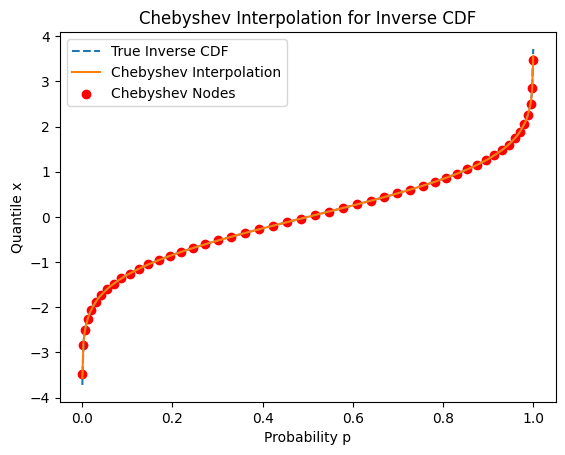

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.interpolate import BarycentricInterpolator
import scipy

def chebyshev_nodes(n, a, b):
    """Generate n Chebyshev nodes in the interval [a, b]."""
    return np.array([0.5 * (a + b) + 0.5 * (b - a) * np.cos((2 * k + 1) * np.pi / (2 * n)) for k in range(n)])

def approximate_inverse_cdf(cdf, n, a=0, b=1):
    """
    Approximate the inverse CDF of a given CDF function using Chebyshev interpolation.
    
    Parameters:
    - cdf: The cumulative distribution function (must be invertible)
    - n: Number of Chebyshev nodes
    - a, b: The probability range for inversion (default [0,1])
    
    Returns:
    - Interpolant function for inverse CDF
    """
    # Generate Chebyshev nodes in the probability domain [0,1]
    p_nodes = chebyshev_nodes(n, a, b)
    
    # Compute the corresponding x-values (inverse CDF)
    x_values = np.array([scipy.optimize.fsolve(lambda x: cdf(x) - p, norm.ppf(p))[0] for p in p_nodes])

    # Create interpolant
    interpolant = BarycentricInterpolator(p_nodes, x_values)
    
    return interpolant


# Define a known CDF (Normal distribution)
cdf = norm.cdf  # Standard normal CDF
n = 50  # Number of interpolation points

# Approximate inverse CDF using Chebyshev interpolation
inverse_cdf_interp = approximate_inverse_cdf(cdf, n)

# Compare with true inverse CDF (ppf function of normal distribution)
p_dense = np.linspace(0.0001, 0.9999, 400)
x_true = norm.ppf(p_dense)
x_interp = inverse_cdf_interp(p_dense)




# Plot results
plt.plot(p_dense, x_true, label='True Inverse CDF', linestyle='dashed')
plt.plot(p_dense, x_interp, label='Chebyshev Interpolation')
plt.scatter(chebyshev_nodes(n, 0, 1), inverse_cdf_interp(chebyshev_nodes(n, 0, 1)), color='red', label='Chebyshev Nodes')
plt.legend()
plt.title("Chebyshev Interpolation for Inverse CDF")
plt.xlabel("Probability p")
plt.ylabel("Quantile x")
plt.show()

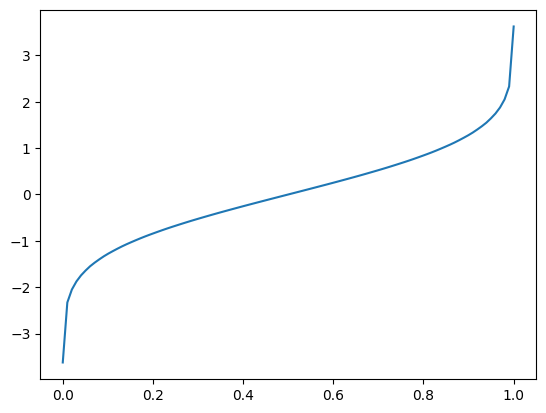

In [9]:
u = np.linspace(0, 1, 100)
y = inverse_cdf_interp(u)
plt.plot(u,y)

# Test of Conditional distribution

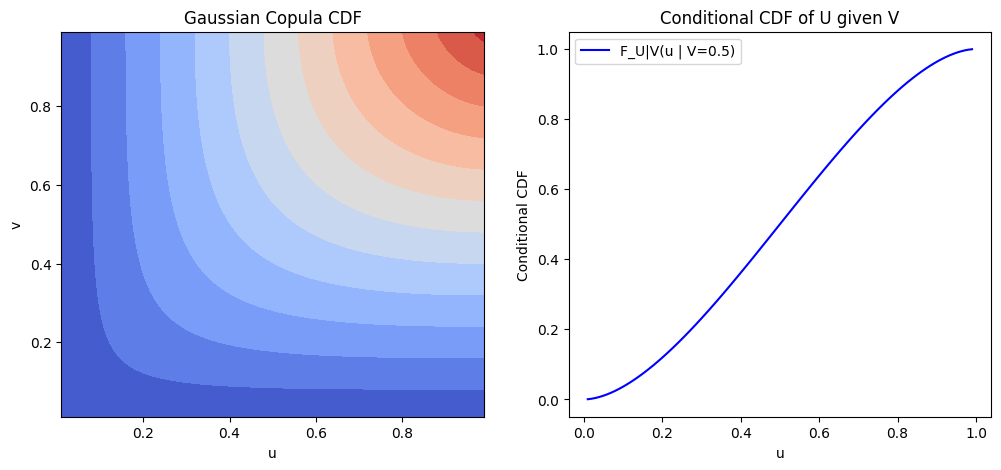

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# Gaussian Copula CDF (numerical approximation)
def gaussian_copula_cdf(u, v, rho):
    norm = stats.norm()
    phi_inv_u, phi_inv_v = norm.ppf(u), norm.ppf(v)
    
    # Bivariate normal CDF
    return stats.multivariate_normal.cdf([phi_inv_u, phi_inv_v], mean=[0, 0], cov=[[1, rho], [rho, 1]])

# Compute the partial derivative wrt v (numerical differentiation)
def conditional_cdf(u, v, rho, epsilon=1e-5):
    return (gaussian_copula_cdf(u, v + epsilon, rho) - gaussian_copula_cdf(u, v, rho)) / epsilon

# Generate grid for visualization
rho = 0.7  # Correlation parameter
u_vals = np.linspace(0.01, 0.99, 100)
v_fixed = 0.5  # Condition on V = 0.5

# Compute the conditional CDF
conditional_cdf_vals = [conditional_cdf(u, v_fixed, rho) for u in u_vals]

# Plot the Copula and Conditional CDF
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# 1. Contour plot of the copula CDF
U, V = np.meshgrid(u_vals, u_vals)
Copula_CDF_vals = np.vectorize(lambda u, v: gaussian_copula_cdf(u, v, rho))(U, V)
ax[0].contourf(U, V, Copula_CDF_vals, levels=15, cmap='coolwarm')
ax[0].set_title("Gaussian Copula CDF")
ax[0].set_xlabel("u")
ax[0].set_ylabel("v")

# 2. Conditional CDF Plot
ax[1].plot(u_vals, conditional_cdf_vals, label=f'F_U|V(u | V={v_fixed})', color='blue')
ax[1].set_title("Conditional CDF of U given V")
ax[1].set_xlabel("u")
ax[1].set_ylabel("Conditional CDF")
ax[1].legend()

plt.show()
